
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs reconstruction of historical and synthetic data

inputs required: 
  * Synthetic offshore waves - emulator output
  * Sea and swell **SWAN simulated cases**

in this notebook:
  * RBF reconstruction simulated storms
  * Generation of hourly nearshore waves with Intradaily Hydrographs



### Workflow:

<div>
<img src="../resources/nb02_03.png" width="400px">
</div>



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..',  '..'))

# teslakit
from teslakit.database import Database, hyswan_db
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL, Intradaily_Hydrograph, Snell_Propagation
from teslakit.climate_emulator import Climate_Emulator
from teslakit.util.time_operations import repair_times_hourly, add_max_storms_mask



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')

# hyswan simulation database
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)


## Define profile to run

In [3]:
prf=11

In [6]:
# --------------------------------------
# aux.

def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target





## SIMULATION Waves Reconstruction

In [5]:
# WIND (Take wind from station 3304: same as used for wavespectra in notebook 09a)

path=r'/media/administrador/HD/Dropbox/Guam/spec_guam'
st=xr.open_dataset(os.path.join(path,'station_' + str(3304) + '.nc'))
st['time']=st['time'].dt.round('H').values
u,ui=np.unique(st.time, return_index=True)
st=st.isel(time=ui)
wind = xr.Dataset({'w': (['time'],st.u10m),
                   'wdir': (['time'],st.udir),

                   }, 
                  coords={'time': st.time.values, 
                        })
print(wind)

<xarray.Dataset>
Dimensions:  (time: 365257)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-09-01
Data variables:
    w        (time) float32 10.600248 10.600248 10.698171 ... 1.963581 2.0884767
    wdir     (time) float32 79.85687 79.85687 79.27295 ... 183.57915 191.91025


In [6]:
# --------------------------------------
# RBF Reconstruction data

# historical sea
wvs_sea_dataset = db_sim.Load('sea_dataset').loc[:,['hs','tp','dir']] 
wvs_sea_subset = db_sim.Load('sea_subset').loc[:,['hs','tp','dir']] 
wvs_sea_target = db_sim.Load('sea_target').reset_index() 

# historical swells
wvs_swl_dataset = db_sim.Load('swl_dataset').loc[:,['hs','tp','dir']]  
wvs_swl_subset = db_sim.Load('swl_subset').loc[:,['hs','tp','dir']] 
wvs_swl_target = db_sim.Load('swl_target').reset_index() 

wvs_swl_target=wvs_swl_target.loc[wvs_swl_target['profile'] ==prf].reset_index().loc[:,['Hsig','TPsmoo','Dir']]
wvs_sea_target=wvs_sea_target.loc[wvs_sea_target['profile'] ==prf].reset_index().loc[:,['Hsig','TPsmoo','Dir']]


In [7]:
# --------------------------------------
# prepare dataset, subset and target data (propagated waves)


# solve target Hs coefficient
wvs_sea_target['Hsig'] = wvs_sea_target['Hsig'] 
wvs_swl_target['Hsig'] = wvs_swl_target['Hsig'] * wvs_swl_subset['hs']


# remove nans (if any) from subset and target
wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swl_subset, wvs_swl_target = fix_target_nans(wvs_swl_subset, wvs_swl_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset = wvs_sea_dataset[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swl_dataset = wvs_swl_dataset[vns_ds].values
wvs_swl_subset = wvs_swl_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swl_target = wvs_swl_target[vns_tgt].values


remove nan data found at target:
     Hsig  TPsmoo  Dir
5     0.0     NaN  NaN
22    0.0     NaN  NaN
33    0.0     NaN  NaN
299   0.0     NaN  NaN


In [8]:
# --------------------------------------
# RBF Reconstruction library

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swl_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swl_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].dropna()
#     data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    # return pandas.dataframe
    return rec_waves


In [11]:
WVS = db.Load_WAVES_hist()
WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])
WVS.sea_Hs.values[:20]

array([       nan, 0.3986713 , 0.52616487, 0.68793213, 0.81281239,
       0.92055558, 1.01912188, 1.12458991, 1.25083676, 1.3707402 ,
       1.45356921, 1.51243522, 1.55898498, 1.53008811, 1.4898874 ,
       1.47317164, 1.46253837, 1.45520476, 1.45121239, 1.45046357])

In [9]:
# --------------------------------------
# Load historical waves families

WVS = db.Load_WAVES_hist()
WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])

# Reconstruct waves by families
WVS_rec = xr.Dataset.from_dataframe(RBF_Reconstruction_families(WVS.to_dataframe()))


# aggregate nearshore variables (Tp from max. energy waves family)
WVS_a = Aggregate_WavesFamilies(WVS_rec, a_tp='max_energy')
WVS_rec = xr.merge([WVS_rec, WVS_a])

# calculate nearshore AWL
WVS_rec['AWL'] = AWL(WVS_rec['Hs'], WVS_rec['Tp'])


# store historical hourly nearshore waves reconstruction
# db.Save_HIST_NEARSHORE(WVS_rec)

ix_scalar: 0,  optimization: 21.40 | interpolation: 15.16
ix_scalar: 1,  optimization: 21.36 | interpolation: 15.20
ix_directional: 2,  optimization: 42.40 | interpolation: 30.40
ix_scalar: 0,  optimization: 8.48 | interpolation: 13.64
ix_scalar: 1,  optimization: 22.19 | interpolation: 14.49
ix_directional: 2,  optimization: 24.79 | interpolation: 29.01
ix_scalar: 0,  optimization: 8.44 | interpolation: 10.53
ix_scalar: 1,  optimization: 22.16 | interpolation: 10.91
ix_directional: 2,  optimization: 24.54 | interpolation: 21.84


In [20]:
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)
HIST_C_h=HIST_C_h.sel(time=slice(WVS_rec.time[0],WVS_rec.time[-1]))
HIST_C_h

<xarray.Dataset>
Dimensions:      (time: 365256)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T01:00:00 ... 2020-09-01
Data variables:
    MJO          (time) float64 ...
    WaterLevels  (time) float32 ...
    swell_2_Dir  (time) float64 ...
    MMSL         (time) float64 ...
    level        (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_1_Hs   (time) float64 ...
    Tp           (time) float64 ...
    AT           (time) float64 ...
    sea_Tp       (time) float64 ...
    DWT          (time) float64 ...
    AWT          (time) float64 ...
    TWL          (time) float64 ...
    AWL          (time) float64 ...
    max_storms   (time) bool ...
    Residual     (time) float64 ...
    Hs           (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_2_Hs   (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Dir      (time) float64 ...

In [11]:
WVS_rec['level']=HIST_C_h['level']
WVS_rec['wind_speed']=wind.w
WVS_rec['wind_dir']=wind.wdir
WVS_rec

<xarray.Dataset>
Dimensions:      (time: 365256)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T01:00:00 ... 2020-09-01
Data variables:
    sea_Hs       (time) float64 -0.6343 -0.6059 -0.5795 ... nan 1.183 1.18
    sea_Tp       (time) float64 3.371 3.912 4.553 4.881 ... nan nan 4.059 3.943
    sea_Dir      (time) float64 337.4 339.5 344.9 349.6 ... nan nan 349.4 347.2
    swell_1_Hs   (time) float64 nan nan nan nan ... 0.9533 0.947 0.9395 0.9332
    swell_1_Tp   (time) float64 nan nan nan nan nan ... 11.33 11.31 11.32 11.36
    swell_1_Dir  (time) float64 nan nan nan nan nan ... 296.8 296.7 296.6 296.8
    swell_2_Hs   (time) float64 nan nan nan nan ... 0.004925 0.02052 0.02145
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 10.18 10.21 12.66 12.73
    swell_2_Dir  (time) float64 nan nan nan nan nan ... 38.1 38.09 17.4 17.44
    Hs           (time) float64 0.6343 0.6059 0.5795 ... 0.947 1.511 1.505
    Tp           (time) float64 nan nan nan nan nan ... 11.33 11.31 4.059 3.943
    Dir          (time) float64 337.4 339.5 344.9 349.6 ... 296.7 315.3 314.3
    AWL          (time) float64 nan nan nan nan ... 0.4752 0.4728 0.2144 0.2078
    level        (time) float64 ...
    wind_speed   (time) float32 10.600248 10.698171 ... 1.963581 2.0884767
    wind_dir     (time) float32 79.85687 79.27295 ... 183.57915 191.91025

In [13]:
WVS = db.Load_WAVES_hist()

1.8538747784934066

In [37]:
%matplotlib inline
a=xr.open_dataset('/media/administrador/HD/Dropbox/Guam/teslakit/data/sites/GUAM/HISTORICAL/OFFSHORE/Residual.nc')
a

<xarray.Dataset>
Dimensions:   (time: 1229425)
Coordinates:
  * time      (time) datetime64[ns] 1880-06-01 ... 2020-09-01
Data variables:
    Residual  (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1

Text(0, 0.5, 'Hs (m)')

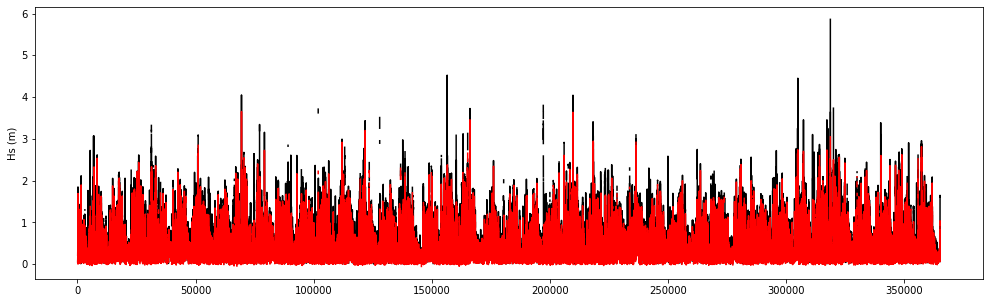

In [18]:
%matplotlib inline
plt.figure(figsize=[17,5])
plt.plot(WVS.swell_1_Hs.values,'k-')
plt.plot(WVS_rec.swell_1_Hs.values,'r-')
plt.ylabel('Hs (m)')

In [15]:
p_s='/media/administrador/HD/Dropbox/Guam/teslakit/data/sites/GUAM/HISTORICAL/NEARSHORE'
WVS_rec.to_netcdf(path=os.path.join(p_s,'Reconstruction_Swan_Hindcast_prf'+ str(prf)))
